# 教師なし学習による異常検知
#### アプローチ
- Isolation Forest
- k-Means
- PCA(SVD)

In [10]:
import numpy as np
from scipy.stats import multivariate_normal
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## サンプルデータの作成

In [70]:
np.random.seed(123)

data1 = np.random.multivariate_normal(mean = np.array([0, 0]), 
                                                                      cov = np.array([[9, 10], 
                                                                                                  [10, 8]]), 
                                                                      size=200)

data2 = np.random.multivariate_normal(mean = np.array([10, 0]), 
                                                                      cov = np.array([[6, 7], 
                                                                                                  [7, 6]]), 
                                                                      size=50)

data3 = np.random.multivariate_normal(mean = np.array([-10, 3]), 
                                                                      cov = np.array([[5, 0], 
                                                                                                  [0, 5]]), 
                                                                      size=30)

data4 = np.random.multivariate_normal(mean = np.array([0, -15]), 
                                                                      cov = np.array([[3, 0], 
                                                                                                  [0, 3]]), 
                                                                      size=10)

data5 = np.random.multivariate_normal(mean = np.array([-6, 12]), 
                                                                      cov = np.array([[3, 0], 
                                                                                                  [0, 3]]), 
                                                                      size=20)

data6 = np.random.multivariate_normal(mean = np.array([15, 15]), 
                                                                      cov = np.array([[2, 0], 
                                                                                                  [0, 2]]), 
                                                                      size=5)

data = np.r_[data1, data2, data3, data4, data5, data6]
print(data.shape)

ss = StandardScaler()
data = ss.fit_transform(data)    # 正規化の実施

(315, 2)


<ipython-input-70-0e6287581ff6>:3: RuntimeWarning: covariance is not positive-semidefinite.
  data1 = np.random.multivariate_normal(mean = np.array([0, 0]),
<ipython-input-70-0e6287581ff6>:8: RuntimeWarning: covariance is not positive-semidefinite.
  data2 = np.random.multivariate_normal(mean = np.array([10, 0]),


(-4.137262982976512, 4.250408655598053)

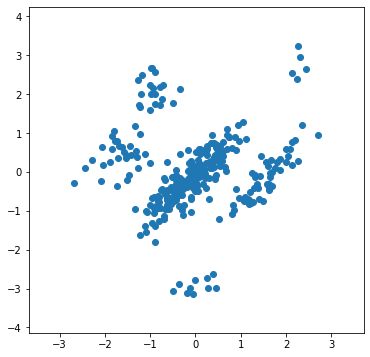

In [71]:
plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:,1])
plt.xlim([data[:,0].min()-1, data[:,0].max()+1])
plt.ylim([data[:,1].min()-1, data[:,1].max()+1])

In [72]:
df = pd.DataFrame(data, columns=['X1','X2'])
display(df.head())
display(df.describe())

,X1,X2
0,0.585422,0.273520
1,-0.433492,-0.077969
2,0.421756,-0.127737
3,1.059368,1.282753
4,-0.835750,-0.748162


,X1,X2
count,3.150000e+02,3.150000e+02
mean,-2.114711e-17,5.498247e-17
std,1.001591e+00,1.001591e+00
min,-2.678331e+00,-3.137263e+00
25%,-6.750226e-01,-4.787722e-01
50%,-5.817005e-02,-5.458348e-02
75%,4.869684e-01,4.626528e-01
max,2.717615e+00,3.250409e+00


In [73]:
df.to_csv('../data/anomaly_detection_sample.csv', index=False)

## 教師なし学習による、異常度のスコアリング

### Isolation Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [74]:
from sklearn.ensemble import IsolationForest

In [75]:
isof = IsolationForest(random_state=123).fit(data)
isof_score = isof.score_samples(data)       # スコアリング結果そのものが指標

In [76]:
df['IF_Score'] = isof_score

(-4.137262982976512, 4.250408655598053)

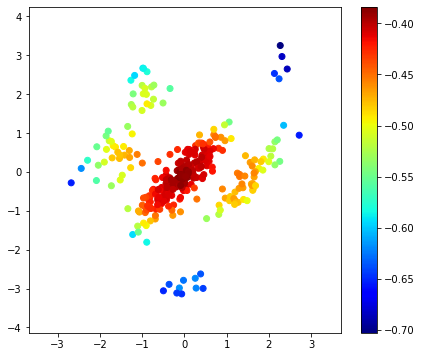

In [77]:
plt.figure(figsize=(7,6))
plt.scatter(df['X1'], df['X2'], c=df['IF_Score'], cmap='jet')
plt.colorbar()
plt.xlim([df['X1'].min()-1, df['X1'].max()+1])
plt.ylim([df['X2'].min()-1, df['X2'].max()+1])

※ 値が小さい（青色）方が異常

### k-Means
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

クラスター分析後、所属数の少ないクラスターを異常と考える

In [78]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

Davies-Bouldin Indexでクラスター数を決定： https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index

In [87]:
n_clst_res = {}
for n_clst in range(3, 15):
    kmeans = KMeans(n_clusters=n_clst, random_state=123).fit(data)
    labels = kmeans.labels_
    n_clst_res[n_clst] = davies_bouldin_score(data, labels)

n_clst_res    # 小さい方が良い

{3: 0.895522867171346,
 4: 0.8430176813713877,
 5: 0.731614538407182,
 6: 0.6195106589863854,
 7: 0.5726912371986776,
 8: 0.5734289204126476,
 9: 0.5542146322972458,
 10: 0.600697305253566,
 11: 0.6130678421729296,
 12: 0.6827508789981018,
 13: 0.6999687755186558,
 14: 0.7361364208065265}

In [88]:
# Davies-Bouldin Indexが示すクラスター数で決定
kmeans = KMeans(n_clusters=9, random_state=1234).fit(data)
kmeans_clst = kmeans.labels_

7     5
5    10
1    20
4    20
2    30
8    30
3    52
6    59
0    89
dtype: int64


<AxesSubplot:>

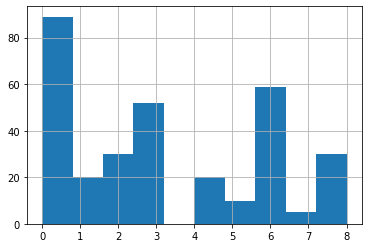

In [89]:
print(pd.Series(kmeans_clst).value_counts(ascending=True))
pd.Series(kmeans_clst).hist()

In [90]:
# クラスター所属数が小さい順にスコアを付与（所属数が少ないクラスターの値は小さい）
df['KM_Score'] = pd.Series(kmeans_clst).map({7:0, 5:1, 1:2, 4:3, 2:4, 8:5, 3:6, 6:7 ,0:8})

In [91]:
df['KM_Score']

0      7
1      8
2      8
3      7
4      6
      ..
310    0
311    0
312    0
313    0
314    0
Name: KM_Score, Length: 315, dtype: int64

(-4.137262982976512, 4.250408655598053)

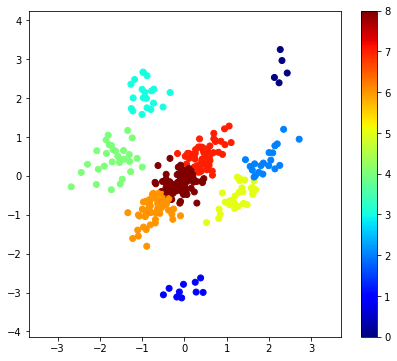

In [92]:
plt.figure(figsize=(7,6))
plt.scatter(df['X1'], df['X2'], c=df['KM_Score'], cmap='jet')
plt.colorbar()
plt.xlim([df['X1'].min()-1, df['X1'].max()+1])
plt.ylim([df['X2'].min()-1, df['X2'].max()+1])

※ 値が小さい（青色）方が異常。小さいクラスター

### PCA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

次元削除した主成分軸（正常部分空間）からの距離　（次元削除したことにより、情報ロスが大きいオブザベーション）  
  
参考: [入門 機械学習による異常検知 - Rによる実践ガイド](https://www.coronasha.co.jp/np/isbn/9784339024913/)

sklearn PCAとTruncatedSVDの比較は[ここ](../PCA/PCA.ipynb)

In [94]:
from sklearn.decomposition import PCA

In [101]:
pca = PCA(n_components=1)     # 1次元に圧縮
pca.fit(data)

PCA(n_components=1)

In [103]:
# 主成分（正常部分空間）
normal_space = pca.transform(data)
print(normal_space.shape)
normal_space[:5,:]     # 先頭5行

(315, 1)


array([[ 0.60736347],
       [-0.36165738],
       [ 0.20790232],
       [ 1.65612973],
       [-1.11999469]])

In [116]:
pca_score = np.sum(data**2, axis=1) - np.sum(normal_space**2, axis=1)    # ベクトル間の距離（元データ - 正常部分空間上データ）
pca_score = -1 * pca_score    # 値が小さいと異常となるように符号を入れ替える
pca_score.shape

(315,)

In [117]:
df['PCA_Score'] = pca_score

(-4.137262982976512, 4.250408655598053)

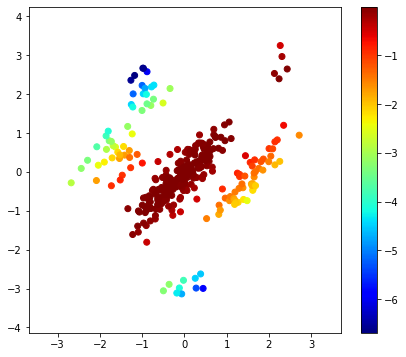

In [118]:
plt.figure(figsize=(7,6))
plt.scatter(df['X1'], df['X2'], c=df['PCA_Score'], cmap='jet')
plt.colorbar()
plt.xlim([df['X1'].min()-1, df['X1'].max()+1])
plt.ylim([df['X2'].min()-1, df['X2'].max()+1])

※ 値が小さい（青色）方が異常。正常部分空間（第一主成分）から遠い